In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import torch
from torch.autograd import Variable

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

In [2]:
from read_results import read_varnames
import saprc99_code.kpp4py as kpp

nvar = 74
varnames = read_varnames("saprc99_code/saprc99_Parameters.f90")[0:nvar]
print(varnames)

['H2SO4', 'HCOOH', 'CCO_OH', 'RCO_OH', 'CCO_OOH', 'RCO_OOH', 'XN', 'XC', 'SO2', 'O1D', 'ALK1', 'BACL', 'PAN', 'PAN2', 'PBZN', 'MA_PAN', 'H2O2', 'N2O5', 'HONO', 'ALK2', 'ALK3', 'TBU_O', 'ALK5', 'ARO2', 'HNO4', 'COOH', 'HOCOO', 'BZNO2_O', 'MEOH', 'ALK4', 'ARO1', 'DCB2', 'DCB3', 'CRES', 'DCB1', 'NPHE', 'ROOH', 'BALD', 'PHEN', 'CO', 'MGLY', 'ACET', 'HNO3', 'ETHENE', 'GLY', 'BZ_O', 'ISOPRENE', 'R2O2', 'TERP', 'METHACRO', 'OLE1', 'ISOPROD', 'OLE2', 'MVK', 'CCHO', 'HCHO', 'RNO3', 'O3P', 'RCHO', 'MEK', 'PROD2', 'O3', 'HO2', 'RO2_N', 'MA_RCO3', 'C_O2', 'BZCO_O2', 'RO2_R', 'NO', 'NO2', 'NO3', 'CCO_O2', 'RCO_O2', 'OH']


In [3]:
df_range = (
    pd.read_csv('saprc99_range.csv', index_col=0)
    .append(pd.DataFrame(np.array([[0.0, 1.0]]), 
                         columns=['min','max'], 
                         index=['SUN']
                        )
           )
)

df_range['mid'] = 0.5*(df_range['min']+df_range['max'])
df_range['span'] = df_range['max'] - df_range['min']
df_range.tail(10)

,min,max,mid,span
C_O2,5.391452e+06,1.419437e+09,7.124145e+08,1.414046e+09
BZCO_O2,1.000000e-08,3.226580e+06,1.613290e+06,3.226580e+06
RO2_R,2.006049e+05,1.824368e+09,9.122844e+08,1.824168e+09
NO,1.006610e+05,9.000156e+11,4.500078e+11,9.000155e+11
NO2,5.003760e+09,1.461165e+12,7.330842e+11,1.456161e+12
NO3,1.742790e+06,1.039629e+10,5.199017e+09,1.039455e+10
CCO_O2,6.779490e+05,5.267318e+08,2.637049e+08,5.260539e+08
RCO_O2,7.110903e+04,3.979400e+08,1.990056e+08,3.978689e+08
OH,9.784155e+04,7.272688e+07,3.641236e+07,7.262904e+07
SUN,0.000000e+00,1.000000e+00,5.000000e-01,1.000000e+00


In [4]:
df_range.loc[['PAN', 'ARO2', 'ARO1', 'HCHO', 'O3', 'NO', 'NO2', 'SUN']]

,min,max,mid,span
PAN,6.560740e+07,4.865127e+11,2.432891e+11,4.864471e+11
ARO2,1.000000e-08,1.323908e+11,6.619542e+10,1.323908e+11
ARO1,1.000000e-08,2.594001e+11,1.297000e+11,2.594001e+11
HCHO,1.708487e+10,6.853611e+11,3.512230e+11,6.682763e+11
O3,8.459007e+11,8.609433e+12,4.727667e+12,7.763533e+12
NO,1.006610e+05,9.000156e+11,4.500078e+11,9.000155e+11
NO2,5.003760e+09,1.461165e+12,7.330842e+11,1.456161e+12
SUN,0.000000e+00,1.000000e+00,5.000000e-01,1.000000e+00


# Make training data

In [5]:
shrink = 0.25

y0_list =  np.random.uniform(df_range['min'] + shrink*df_range['span'],
                             df_range['max'] - shrink*df_range['span'], 
                             size=(5000, nvar+1))

y0_list.shape

(5000, 75)

In [6]:
%time y1_list = kpp.onestep(y0_list.T).T
y1_list.shape

CPU times: user 3.78 s, sys: 41.7 ms, total: 3.82 s
Wall time: 3.89 s


(5000, 74)

# Normalize data

In [7]:
normalizer = StandardScaler()
normalizer.fit(y0_list[:,0:74])

StandardScaler(copy=True, with_mean=True, with_std=True)

In [8]:
X_train = np.append(normalizer.transform(y0_list[:,0:74]), 
                    y0_list[:,-1:], 
                    axis=1)
X_train.shape

(5000, 75)

In [9]:
Y_train = normalizer.transform(y1_list)
Y_train.std(axis=0)

array([1.00074385, 1.00231999, 1.00000134, 1.00000092, 0.99993993,
       0.99998192, 1.10937947, 1.07906445, 0.98030295, 0.93648243,
       0.99456103, 1.07362165, 0.89600183, 0.95459146, 0.98155277,
       1.47242328, 0.9518329 , 1.47650601, 0.21689978, 0.97806357,
       0.9524404 , 0.9748209 , 0.85381541, 0.68072307, 0.96196441,
       0.88858625, 0.88411165, 3.90612559, 0.98064831, 0.91865086,
       0.89434343, 0.93615519, 1.17862313, 0.21491132, 0.62708048,
       1.22158058, 0.81266483, 0.74688308, 0.34052136, 0.99608866,
       0.73363109, 0.99842875, 1.01266256, 0.83036518, 0.74137469,
       0.66482045, 0.21035668, 0.61797727, 0.02976803, 0.64657964,
       0.54524251, 0.52490272, 0.09808367, 0.79978878, 0.75508586,
       0.75779974, 0.93346023, 0.75567049, 0.73070066, 0.97705846,
       0.85167464, 0.95980457, 0.8388928 , 0.7041222 , 0.70628369,
       0.23791501, 0.2672395 , 0.47330606, 0.13237732, 1.1092472 ,
       0.04373905, 0.17563823, 0.1206859 , 0.19032597])

# Fit ANN

In [10]:
x_torch = Variable(torch.from_numpy(X_train))
y_torch = Variable(torch.from_numpy(Y_train))

In [11]:
H1, H2 = 100, 100

model = torch.nn.Sequential(
    torch.nn.Linear(75, H1),
    #torch.nn.ReLU(),
    torch.nn.Tanh(),
    #torch.nn.BatchNorm1d(H1),
    torch.nn.Linear(H1, H2),
    #torch.nn.ReLU(),
    torch.nn.Tanh(),
    #torch.nn.BatchNorm1d(H2),
    torch.nn.Linear(H2, 74)
).double()

In [12]:
loss_fn = torch.nn.MSELoss()

optimizer = torch.optim.LBFGS(model.parameters(), lr=1.0)
#optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)

for t in range(200):
    
    def closure():
        optimizer.zero_grad()
        y_pred = model(x_torch)
        loss = loss_fn(y_pred, y_torch)
        loss.backward()
        return loss
    optimizer.step(closure)
    
    if (t+1)%20==0:
        y_pred = model(x_torch)
        loss = loss_fn(y_pred, y_torch)
        print(t+1, loss.data[0])

20 0.003717085581630228
40 0.0024070353370176946
60 0.0018235006440416946
80 0.0015130970041673866
100 0.0013254028281078556
120 0.001201965241331114
140 0.0011217914727796232
160 0.0010602353212886115
180 0.001012128798340678
200 0.0009691388619992808


In [13]:
%%time 
y_pred = model(x_torch)
y_pred_numpy = y_pred.data.numpy()

CPU times: user 46.8 ms, sys: 5.62 ms, total: 52.4 ms
Wall time: 21.7 ms


In [14]:
r2_score(y_pred_numpy, Y_train, multioutput='raw_values')

array([0.99977282, 0.99964862, 0.99969656, 0.99976086, 0.99982266,
       0.99980415, 0.99960251, 0.99959755, 0.9997844 , 0.99893306,
       0.99973532, 0.99859335, 0.99911594, 0.9984754 , 0.99860229,
       0.99889249, 0.9996208 , 0.99892407, 0.97538512, 0.99978707,
       0.99956024, 0.99794357, 0.99948724, 0.99750629, 0.99716219,
       0.99945322, 0.99757301, 0.99960293, 0.99973244, 0.99955773,
       0.99954253, 0.99700532, 0.99811088, 0.98407849, 0.9979625 ,
       0.9985521 , 0.99933916, 0.99935036, 0.95783619, 0.99979508,
       0.99864308, 0.99974519, 0.99968877, 0.99947312, 0.99886666,
       0.99495907, 0.95306449, 0.996762  , 0.7608473 , 0.99815645,
       0.99784549, 0.99708237, 0.91654458, 0.99789444, 0.99879536,
       0.99873279, 0.99944756, 0.99824631, 0.99876903, 0.99971843,
       0.99946112, 0.999463  , 0.99846352, 0.99604144, 0.99663946,
       0.99069357, 0.97622922, 0.99743524, 0.9906761 , 0.99966519,
       0.96428256, 0.98498537, 0.98012998, 0.99586877])

In [15]:
r2_score(y_pred_numpy, Y_train), r2_score(y_pred_numpy, Y_train, multioutput='variance_weighted')

(0.9912976151214773, 0.9989228850479624)

(-10, 10)

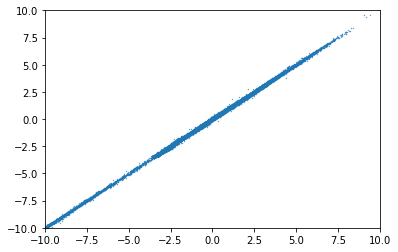

In [16]:
plt.scatter(y_pred_numpy, Y_train, s=0.1)
plt.xlim(-10,10)
plt.ylim(-10,10)

# Test set

In [17]:
shrink = 0.25

y0_test = np.random.uniform(df_range['min'] + shrink*df_range['span'],
                           df_range['max'] - shrink*df_range['span'], 
                           size=(5000, nvar+1))

y0_list.shape

(5000, 75)

In [18]:
%time y1_test = kpp.onestep(y0_test.T).T

CPU times: user 3.72 s, sys: 18.4 ms, total: 3.73 s
Wall time: 3.73 s


In [19]:
X_test = np.append(normalizer.transform(y0_test[:,0:74]), 
                   y0_test[:,-1:], 
                   axis=1)
Y_test = normalizer.transform(y1_test)

In [20]:
%%time
X_torch_test = Variable(torch.from_numpy(X_test))
y_test_pred = model(X_torch_test).data.numpy()

CPU times: user 37.5 ms, sys: 6.57 ms, total: 44.1 ms
Wall time: 26 ms


In [21]:
r2_score(y_test_pred, Y_test), r2_score(y_test_pred, Y_test, multioutput='variance_weighted')

(0.9903689419488402, 0.9987739239609157)

In [22]:
relerr = np.abs(y_test_pred/Y_test - 1) # relative error
relerr.mean(), relerr.max()

(0.14658258609550823, 9393.67052924388)

In [23]:
abserr = np.abs(y_test_pred-Y_test) # absolute error
abserr.mean(), abserr.max()

(0.021734201997679888, 1.6325557468604117)

(-10, 10)

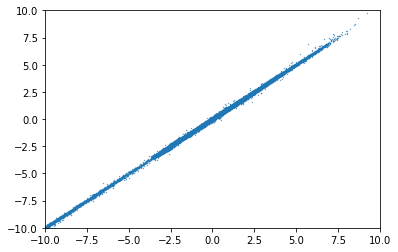

In [24]:
plt.scatter(y_test_pred, Y_test, s=0.1)
plt.xlim(-10,10)
plt.ylim(-10,10)

In [25]:
r2_test = r2_score(y_test_pred, Y_test, multioutput='raw_values')
r2_test.sort()

(-1, 1)

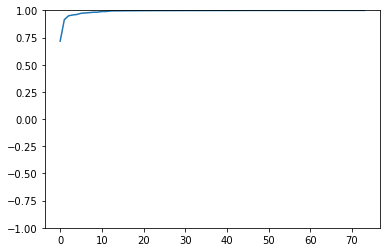

In [26]:
plt.plot(r2_test)
plt.ylim([-1,1])